# Introduction

Course: Deep Learing

Author: Oai Tran

Institution: University of Virginia — School of Data Science

Date: 11/07/2025

Notebook Type: Educational / Research — End-to-End Implementation


## Overview
This notebook is the end-to-end process of the final project. The goal of the final project is to predict a stock price and determine whether it is a buy/sell/hold position. 

MTCH


#### Stage 1

In [1]:
# ==========================================================
#  Stage 1 — MTCH Forecast (v2.6)
#  Δ-Target + Conv1D→LSTM + Macro (VIX) | CuDNN-safe & Merge-Safe
# ==========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
import os
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from datetime import datetime, timedelta


In [2]:

# ----------------------------------------------------------
# 0. Reproducibility & environment setup
# ----------------------------------------------------------
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_USE_CUDNN_RNN"] = "0"   # disable CuDNN RNN kernels
print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [3]:

# ----------------------------------------------------------
# 1. Load data (MTCH + VIX)
# ----------------------------------------------------------
start_date, end_date = "2017-01-01", "2025-09-10"

raw = yf.Ticker("MTCH").history(start=start_date, end=end_date, auto_adjust=False)
vix_raw = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)

raw = raw[["Open", "High", "Low", "Close", "Volume"]].dropna()
vix_raw = vix_raw[["Close"]].rename(columns={"Close": "VIX_Close"}).dropna()

# ----------------------------------------------------------
# 1.5 Align and clean data
# ----------------------------------------------------------
# Outer join → keep all dates; forward-fill VIX; drop non-trading days for VOO
df = raw.join(vix_raw, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

print(f"After merge: {df.shape[0]} rows remain ({df.index.min().date()} → {df.index.max().date()})")



After merge: 2183 rows remain (2017-01-03 → 2025-09-09)


/tmp/ipykernel_462463/3237348641.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")


/home/dzn7nf/.local/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


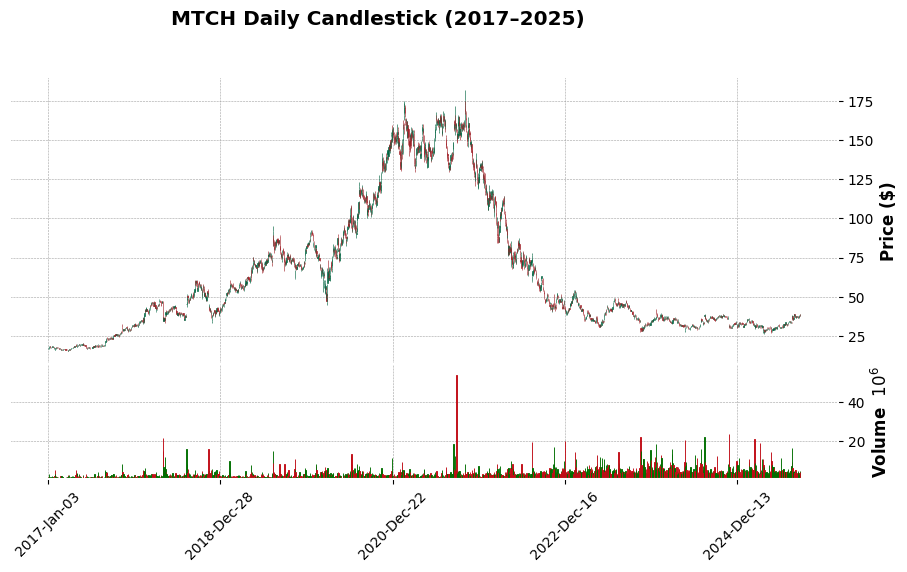

In [4]:
mpf.plot(
    raw,
    type="candle", 
    style="charles",   # clean style
    title="MTCH Daily Candlestick (2017–2025)",
    ylabel="Price ($)",
    volume=True,       # adds volume below chart
    figratio=(12,6)
)

In [5]:
# ----------------------------------------------------------
# 2. Feature engineering
# ----------------------------------------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, min_periods=1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"] - df["VIX_Close"].rolling(20, min_periods=1).mean()) / \
                     df["VIX_Close"].rolling(20, min_periods=1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)



In [6]:
# ----------------------------------------------------------
# 3. Target = next-day return (Δ target)
# ----------------------------------------------------------
df["TargetRet1"] = (df["Close"].shift(-1) / df["Close"] - 1.0)
df["PrevClose"]  = df["Close"]
df = df.dropna(subset=["TargetRet1"]).copy()


In [7]:
# ----------------------------------------------------------
# 4. Scale features only (not target)
# ----------------------------------------------------------
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols, index=df.index)

y_all      = df["TargetRet1"].values.astype("float32")
prev_close = df["PrevClose"].values.astype("float32")
dates_all  = df.index

print(f"Scaled features shape: {scaled_df.shape}")



Scaled features shape: (2182, 10)


In [8]:
# ----------------------------------------------------------
# 5. Sequence builder
# ----------------------------------------------------------
def make_sequences(X_df, y, prev_close, dates, window=12):
    X, y_out, prev_c, d_out = [], [], [], []
    for i in range(len(X_df) - window):
        X.append(X_df.iloc[i:i+window].values)
        y_out.append(y[i+window-1])           # predict ΔClose for t+1
        prev_c.append(prev_close[i+window-1]) # previous close
        d_out.append(dates[i+window])         # target date
    return np.array(X), np.array(y_out), np.array(prev_c), np.array(d_out)

window = 12
X, y, prev_c, dts = make_sequences(scaled_df, y_all, prev_close, dates_all, window=window)
split = int(len(X)*0.8)

X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]
pc_tr, pc_te = prev_c[:split], prev_c[split:]
dt_tr, dt_te = dts[:split], dts[split:]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}")



Train: (1736, 12, 10),  Test: (434, 12, 10)


In [9]:
# ----------------------------------------------------------
# 6. Conv1D → LSTM model (CuDNN-safe)
# ----------------------------------------------------------
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True, unroll=True,
             activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        LSTM(32, unroll=True, activation='tanh', recurrent_activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next-day return
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt, loss='mse')
    return model

model = build_model((window, X_tr.shape[2]))
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=120,
    batch_size=16,
    verbose=1,
    callbacks=[es]
)



'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/120


W0000 00:00:1763569792.066020  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.082984  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.103246  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.105755  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.110077  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.134017  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.134171  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.136431  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569792.136529  462554 gp

  2/109 [..............................] - ETA: 5s - loss: 0.0014  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763569794.747866  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.747955  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.748021  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.748074  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.748127  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.748190  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.748265  462554 gpu_timer.cc:114] Skipping

 45/109 [===========>..................] - ETA: 0s - loss: 9.7275e-04

W0000 00:00:1763569794.939523  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939632  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939707  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939775  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939842  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939917  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.939984  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.940053  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569794.940119  462554 gp

109/109 [==============================] - ETA: 0s - loss: 9.8309e-04

W0000 00:00:1763569795.313310  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.313740  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.313798  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.313873  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.313953  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.314019  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.314092  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.314154  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.314221  462554 gp

109/109 [==============================] - 6s 9ms/step - loss: 9.8309e-04 - val_loss: 5.6814e-04
Epoch 2/120
 18/109 [===>..........................] - ETA: 0s - loss: 8.3100e-04

W0000 00:00:1763569795.660072  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676065  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676167  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676271  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676363  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676431  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676521  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676594  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569795.676666  462554 gp

109/109 [==============================] - 1s 5ms/step - loss: 9.7607e-04 - val_loss: 5.6222e-04
Epoch 3/120
 18/109 [===>..........................] - ETA: 0s - loss: 0.0010    

W0000 00:00:1763569796.230085  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230487  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230547  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230621  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230702  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230777  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230851  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230917  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569796.230984  462554 gp

109/109 [==============================] - 0s 4ms/step - loss: 9.7208e-04 - val_loss: 5.8590e-04
Epoch 4/120
109/109 [==============================] - 0s 4ms/step - loss: 9.8471e-04 - val_loss: 5.6519e-04
Epoch 5/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7490e-04 - val_loss: 5.6409e-04
Epoch 6/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7694e-04 - val_loss: 5.6973e-04
Epoch 7/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7775e-04 - val_loss: 5.9779e-04
Epoch 8/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7528e-04 - val_loss: 5.6350e-04
Epoch 9/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7279e-04 - val_loss: 5.6648e-04
Epoch 10/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7358e-04 - val_loss: 5.6219e-04
Epoch 11/120
109/109 [==============================] - 0s 4ms/step - loss: 9.7638e-04 - val_loss: 5.6694e-04
Epoch 12/120
109/109 [=======

In [10]:
# ----------------------------------------------------------
# 7. Predict → reconstruct prices
# ----------------------------------------------------------
y_pred_ret = model.predict(X_te).flatten()
y_pred_price = pc_te * (1.0 + y_pred_ret)
y_true_price = pc_te * (1.0 + y_te)

# ----------------------------------------------------------
# 8. Metrics
# ----------------------------------------------------------
mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
mae  = mean_absolute_error(y_true_price, y_pred_price)
rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
r2   = r2_score(y_true_price, y_pred_price)

print(f"MAPE={mape:.2f}% | MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.3f}")



14/14 [==============================] - 0s 4ms/step
MAPE=1.63% | MAE=$0.54 | RMSE=$0.80 | R²=0.918


W0000 00:00:1763569806.306496  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306583  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306639  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306712  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306798  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306863  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.306936  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.307006  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569806.307076  462554 gp

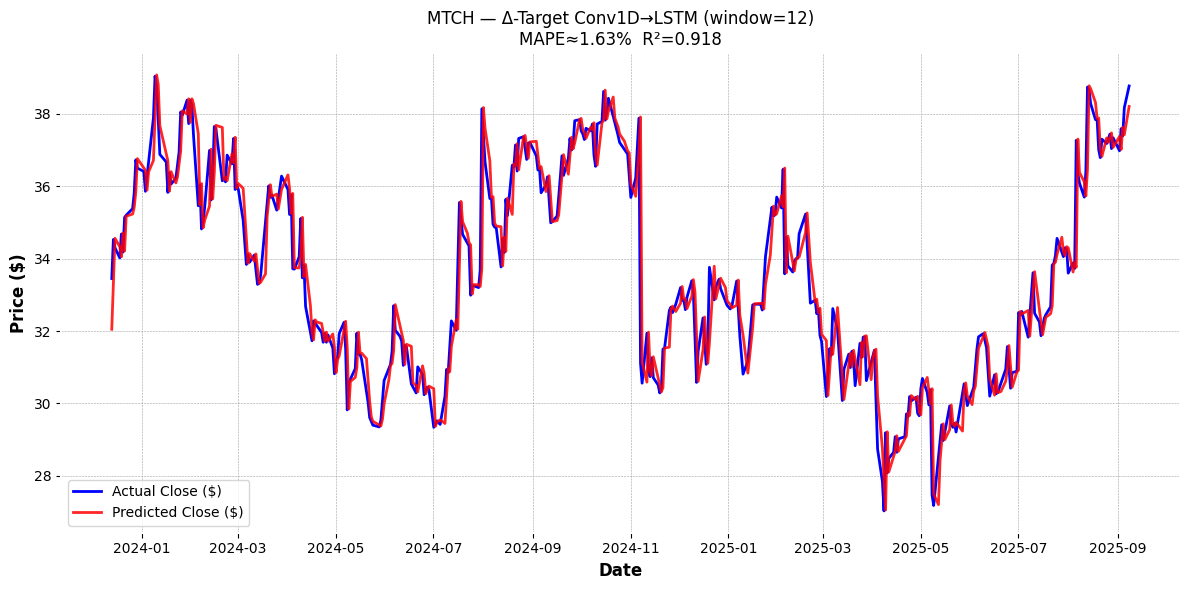

In [11]:
# ----------------------------------------------------------
# 8. Plot results
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(dt_te, y_true_price, label="Actual Close ($)", color="blue")
plt.plot(dt_te, y_pred_price, label="Predicted Close ($)", color="red", alpha=0.85)
plt.title(f"MTCH — Δ-Target Conv1D→LSTM (window={window})\nMAPE≈{mape:.2f}%  R²={r2:.3f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 9. Save model + scaler
# ----------------------------------------------------------
os.makedirs("models", exist_ok=True)
model.save("models/MTCH_stage1_v26.h5")
joblib.dump(scaler, "models/MTCH_scaler_v26.pkl")
print("Model & scaler saved to ./models/")

Model & scaler saved to ./models/


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Stage 2

W0000 00:00:1763569807.203020  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203109  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203163  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203235  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203321  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203386  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203466  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203539  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569807.203610  462554 gp

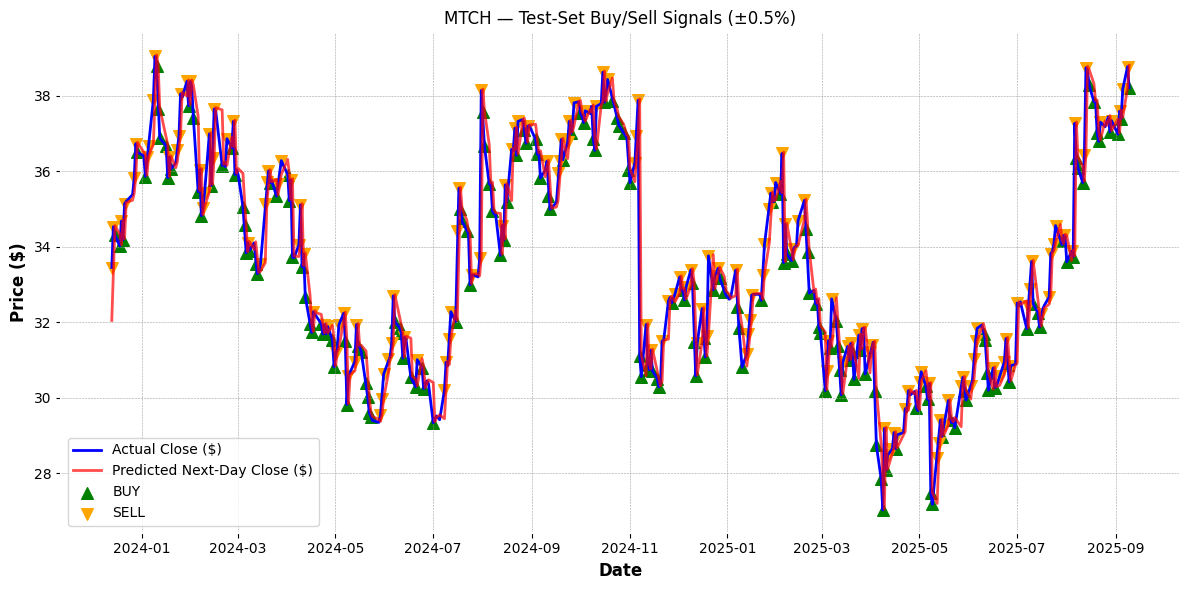

=== TEST-SET RESULTS ===
Strategy  → CAGR -85.75%, Vol 23.56%, Sharpe -3.64
Buy&Hold → CAGR 10.78%, Vol 37.62%, Sharpe 0.29


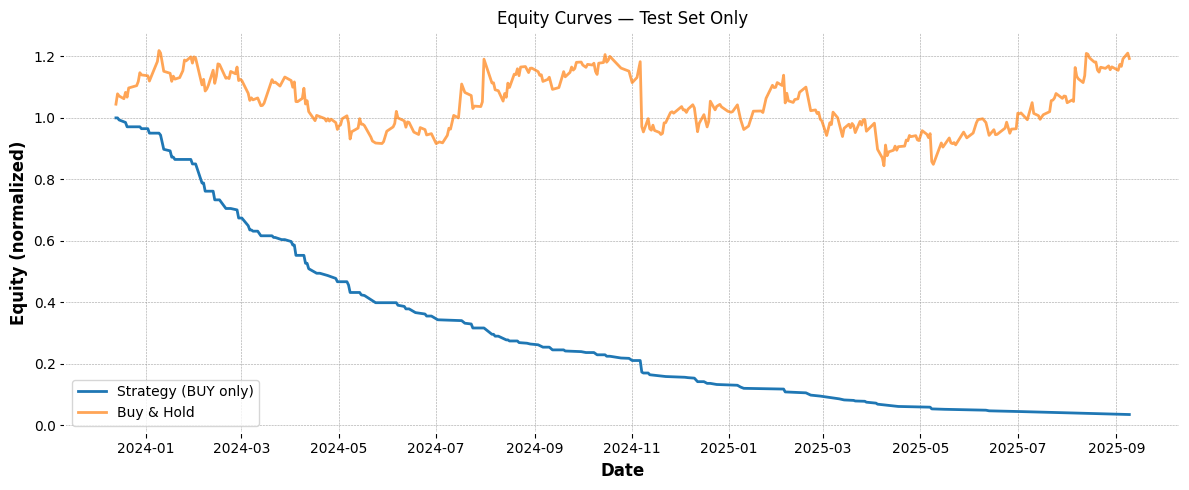


Recent test-period signals:
                              Actual  Predicted    Gap(%) Signal
2025-08-26 04:00:00+00:00  37.299999  37.213596 -0.231643   HOLD
2025-08-27 04:00:00+00:00  37.439999  37.333704 -0.283907   HOLD
2025-08-28 04:00:00+00:00  37.040001  37.473830  1.171244    BUY
2025-08-29 04:00:00+00:00  37.340000  37.073470 -0.713791   SELL
2025-09-02 04:00:00+00:00  36.980000  37.373741  1.064741    BUY
2025-09-03 04:00:00+00:00  37.590000  37.013415 -1.533879   SELL
2025-09-04 04:00:00+00:00  37.389999  37.623967  0.625748    BUY
2025-09-05 04:00:00+00:00  38.169998  37.423785 -1.954972   SELL
2025-09-08 04:00:00+00:00  38.770000  38.204489 -1.458632   SELL
2025-09-09 04:00:00+00:00  38.209999  38.805033  1.557274    BUY
Saved: artifacts/stage2_signals_MTCH.csv
Saved: models/stage2_config_MTCH.pkl
Saved placeholder model: models/stage2_direct_signal_placeholder_MTCH.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# ==========================================================
#  Stage 2 (Direct Signal, Test Only)
#  v2.4 — Plot & Backtest only on Stage-1 test split
# ==========================================================




# ----------------------------
# Config
# ----------------------------
TICKER = "MTCH"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 12
THRESH = 0.005   # 0.5% price gap threshold for Buy/Sell
TEST_RATIO = 0.2


# ----------------------------
# Load price data ( + VIX)
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
voo = voo[["Open","High","Low","Close","Volume"]].dropna()
vix = vix[["Close"]].rename(columns={"Close":"VIX_Close"}).dropna()

df = voo.join(vix, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# ----------------------------
# Load Stage-1 model + scaler
# ----------------------------
model_path = "models/MTCH_stage1_v26.h5"
scaler_path = "models/MTCH_scaler_v26.pkl"
assert os.path.exists(model_path), "Stage-1 model not found!"
assert os.path.exists(scaler_path), "Stage-1 scaler not found!"

model = tf.keras.models.load_model(model_path, compile=False)
scaler = joblib.load(scaler_path)

# ----------------------------
# Feature engineering (same schema)
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20,1).mean()) / df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open","High","Low","Close","Volume",
    "Ret1","Momentum5","Volatility5","LogVolume","VIX_Z"
]
scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Build rolling input windows
# ----------------------------
def make_seq(Xdf, window=WINDOW):
    Xs, dates = [], []
    for i in range(len(Xdf)-window):
        Xs.append(Xdf.iloc[i:i+window].values)
        dates.append(Xdf.index[i+window])
    return np.array(Xs), np.array(dates)

Xseq, dates = make_seq(scaled_df, window=WINDOW)
pred_ret = model.predict(Xseq, verbose=0).flatten()

# ----------------------------
# Reconstruct predicted prices
# ----------------------------
close_vals = df["Close"].values
pred_price = close_vals[WINDOW-1:-1] * (1 + pred_ret)
actual_price = close_vals[WINDOW:]
dates = np.array(dates)

# ----------------------------
# Split train/test (chronological)
# ----------------------------
split_idx = int(len(pred_price)*(1-TEST_RATIO))
pred_price_test = pred_price[split_idx:]
actual_price_test = actual_price[split_idx:]
dates_test = dates[split_idx:]

# ----------------------------
# Generate BUY / SELL / HOLD on test only
# ----------------------------
gap = (pred_price_test - actual_price_test) / actual_price_test
signals = np.zeros_like(pred_price_test)
signals[gap > THRESH]  = 1    # BUY
signals[gap < -THRESH] = -1   # SELL
signal_labels = np.where(signals==1,"BUY",np.where(signals==-1,"SELL","HOLD"))

df_signals = pd.DataFrame({
    "Actual": actual_price_test,
    "Predicted": pred_price_test,
    "Gap(%)": gap*100,
    "Signal": signal_labels
}, index=dates_test)

# ----------------------------
# Plot (TEST only)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_signals.index, df_signals["Actual"], label="Actual Close ($)", color="blue")
plt.plot(df_signals.index, df_signals["Predicted"], label="Predicted Next-Day Close ($)", color="red", alpha=0.7)
plt.scatter(df_signals.index[df_signals["Signal"]=="BUY"], df_signals["Actual"][df_signals["Signal"]=="BUY"], 
            marker="^", color="green", label="BUY", s=70)
plt.scatter(df_signals.index[df_signals["Signal"]=="SELL"], df_signals["Actual"][df_signals["Signal"]=="SELL"], 
            marker="v", color="orange", label="SELL", s=70)
plt.title(f"{TICKER} — Test-Set Buy/Sell Signals (±{THRESH*100:.1f}%)")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ----------------------------
# Simple backtest (TEST only)
# ----------------------------
returns = pd.Series(df["Close"]).pct_change().reindex(df_signals.index).fillna(0)
positions = np.where(df_signals["Signal"]=="BUY", 1.0, 0.0)
strategy_returns = returns * positions
eq_curve = (1 + strategy_returns).cumprod()
bh_curve = (1 + returns).cumprod()

def ann_metrics(r):
    cagr = (1.0 + r).prod() ** (252/len(r)) - 1.0
    vol  = r.std() * np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    return cagr, vol, sharpe

cagr_s, vol_s, sh_s = ann_metrics(strategy_returns)
cagr_b, vol_b, sh_b = ann_metrics(returns)

print(f"=== TEST-SET RESULTS ===")
print(f"Strategy  → CAGR {cagr_s:.2%}, Vol {vol_s:.2%}, Sharpe {sh_s:.2f}")
print(f"Buy&Hold → CAGR {cagr_b:.2%}, Vol {vol_b:.2%}, Sharpe {sh_b:.2f}")

plt.figure(figsize=(12,5))
plt.plot(eq_curve.index, eq_curve.values, label="Strategy (BUY only)")
plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curves — Test Set Only")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("\nRecent test-period signals:")
print(df_signals.tail(10))


os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# 1 Save signal dataframe (test predictions)
df_signals.to_csv("artifacts/stage2_signals_MTCH.csv")
print("Saved: artifacts/stage2_signals_MTCH.csv")

# 2 Save the rule parameters as a tiny dict (so we can reload later)
stage2_config = {
    "ticker": TICKER,
    "window": WINDOW,
    "threshold": THRESH,
    "test_ratio": TEST_RATIO,
    "feature_cols": feature_cols,
    "metrics": {
        "strategy_cagr": float(cagr_s),
        "strategy_vol":  float(vol_s),
        "strategy_sharpe": float(sh_s)
    }
}
joblib.dump(stage2_config, "models/stage2_config_MTCH.pkl")
print("Saved: models/stage2_config_MTCH.pkl")

# 3 Optional: save a lightweight “direct-signal model” placeholder
# (just to mark this stage so ensemble loader can find it)
placeholder = Sequential([Dense(1, input_shape=(1,))])
placeholder.save("models/stage2_direct_signal_placeholder_MTCH.h5")
print("Saved placeholder model: models/stage2_direct_signal_placeholder_MTCH.h5")



In [14]:
# ==========================================================
#  Stage 2 — CNN + SVM Training and Save
# ==========================================================

# ----------------------------
# Config
# ----------------------------
#TICKER = "VOO"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 7
EPOCHS, BATCH = 40, 32
os.makedirs("models", exist_ok=True)

# ----------------------------
# Load LW + VIX
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
df = voo.join(vix[["Close"]].rename(columns={"Close":"VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df[["Open","High","Low","Close","Volume","VIX_Close"]].dropna()

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"]-df["VIX_Close"].rolling(20,1).mean())/df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)

features = ["Open","High","Low","Close","Volume","Ret1","Momentum5",
            "Volatility5","LogVolume","VIX_Z"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# ----------------------------
# Build CNN “images” and labels
# ----------------------------
def make_seq(df_scaled, horizon=1, window=WINDOW):
    X, y = [], []
    closes = df["Close"].values
    for i in range(len(df_scaled)-window-horizon):
        X.append(df_scaled.iloc[i:i+window].values.T)
        fwd_ret = (closes[i+window+horizon-1]-closes[i+window-1]) / closes[i+window-1]
        y.append(1 if fwd_ret>0 else 0)  # 1=Up, 0=Down
    return np.array(X), np.array(y)

X, y = make_seq(scaled_df)
X = X[..., np.newaxis]
print("Dataset:", X.shape, y.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# CNN model
# ----------------------------
inp = Input(shape=(X.shape[1], X.shape[2], 1))
x = Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(2, activation="softmax")(x)

cnn = Model(inp, out)
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
es = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
cnn.fit(Xtr, ytr, validation_data=(Xte, yte),
        epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)

cnn.save("models/stage2_cnn_MTCH.h5")
print("Saved: models/stage2_cnn_MTCH.h5")

# ----------------------------
# SVM on CNN embeddings
# ----------------------------
embed_model = Model(inputs=cnn.input, outputs=cnn.layers[-3].output)
emb_tr = embed_model.predict(Xtr, verbose=0)
emb_te = embed_model.predict(Xte, verbose=0)

svm = SVC(kernel="rbf", probability=True)
svm.fit(emb_tr, ytr)
acc = svm.score(emb_te, yte)
print(f"SVM accuracy: {acc:.3f}")
joblib.dump(svm, "models/stage2_svm_MTCH.pkl")
print("Saved: models/stage2_svm_MTCH.pkl")


Dataset: (2174, 10, 7, 1) (2174,)
Epoch 1/40


W0000 00:00:1763569808.920409  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.921229  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924164  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924264  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924338  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924428  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924558  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.924669  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569808.947910  462554 gp

17/55 [========>.....................] - ETA: 0s - loss: 1.1723 - accuracy: 0.5000

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763569809.617379  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.617652  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.617724  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.617814  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.617882  462554 gpu_timer.cc:114] Skipping the delay kernel, measu

55/55 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.5296

W0000 00:00:1763569809.821520  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821608  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821667  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821738  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821812  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821901  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.821976  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.822071  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569809.822159  462554 gp

55/55 [==============================] - 2s 9ms/step - loss: 0.8667 - accuracy: 0.5296 - val_loss: 0.6939 - val_accuracy: 0.4943
Epoch 2/40
55/55 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5193

W0000 00:00:1763569810.102459  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102549  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102608  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102680  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102745  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102833  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102907  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.102997  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.103077  462554 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.5193 - val_loss: 0.6930 - val_accuracy: 0.4920
Epoch 3/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5244 - val_loss: 0.6928 - val_accuracy: 0.4966
Epoch 4/40
 1/55 [..............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.4062

W0000 00:00:1763569810.337607  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.337695  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.337753  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.337825  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.337890  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.337977  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.338053  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.338141  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.338221  462554 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5336 - val_loss: 0.6931 - val_accuracy: 0.5241
Epoch 5/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6887 - accuracy: 0.5320

W0000 00:00:1763569810.677058  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677145  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677203  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677259  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677313  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677386  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677478  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677556  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569810.677633  462554 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5359 - val_loss: 0.6932 - val_accuracy: 0.5195
Epoch 6/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5382 - val_loss: 0.6910 - val_accuracy: 0.5149
Epoch 7/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5325 - val_loss: 0.6913 - val_accuracy: 0.5172
Epoch 8/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5336 - val_loss: 0.6939 - val_accuracy: 0.4989
Epoch 9/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5434 - val_loss: 0.6937 - val_accuracy: 0.5080
Epoch 10/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5618 - val_loss: 0.6984 - val_accuracy: 0.4966
Saved: models/stage2_cnn_MTCH.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SVM accuracy: 0.501
Saved: models/stage2_svm_MTCH.pkl


### Stage 3

In [15]:
# ==========================================================
#  Predict next-day open and close price + signal
#  Interactive Jupyter version
# ==========================================================


# ----------------------------
# Config
# ----------------------------
VIX = "^VIX"
WINDOW_LSTM = 12
WINDOW_CNN = 7
THRESH = 0.02  # 2% threshold for signal
LOOKBACK = 200  # days before target date for context

# ----------------------------
# Ask user inputs
# ----------------------------
ticker = input("Enter stock ticker (e.g., VOO, AAPL, MSFT): ").strip().upper()
while True:
    date_str = input("Enter date (YYYY-MM-DD): ").strip()
    try:
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        break
    except ValueError:
        print("Invalid format. Please use YYYY-MM-DD (e.g., 2025-11-06).")

# ----------------------------
# Load models
# ----------------------------
stage1_path = "models/MTCH_stage1_v26.h5"
scaler_path = "models/MTCH_scaler_v26.pkl"
cnn_path = "models/stage2_cnn_MTCH.h5"
svm_path = "models/stage2_svm_MTCH.pkl"

assert os.path.exists(stage1_path), "Missing Stage 1 model"
assert os.path.exists(scaler_path), "Missing Stage 1 scaler"
model_stage1 = tf.keras.models.load_model(stage1_path, compile=False)
scaler = joblib.load(scaler_path)

cnn_model, svm = None, None
if os.path.exists(cnn_path) and os.path.exists(svm_path):
    cnn_model = tf.keras.models.load_model(cnn_path, compile=False)
    svm = joblib.load(svm_path)

# ----------------------------
# Load price data
# ----------------------------
start_date = (target_date - timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
end_date = (target_date + timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} and VIX data up to {target_date.date()}...")
stock = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker(VIX).history(start=start_date, end=end_date, auto_adjust=False)

if stock.empty:
    raise ValueError(f"No data found for {ticker}. Check the ticker symbol.")

df = stock.join(vix[["Close"]].rename(columns={"Close": "VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"] = df["Close"].pct_change().fillna(0.0)
df["Momentum5"] = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, 1).std().fillna(0.0)
df["LogVolume"] = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20, 1).mean()) / df["VIX_Close"].rolling(20, 1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Stage 1 — LSTM price predictions (Open + Close)
# ----------------------------
X_last = scaled_df.iloc[-WINDOW_LSTM:].values.reshape(1, WINDOW_LSTM, -1)

# predict close
pred_ret_close = model_stage1.predict(X_last, verbose=0).flatten()[0]
pred_close_price = df["Close"].iloc[-1] * (1 + pred_ret_close)

# predict open (shift features by 1 day to simulate next open)
X_last_shifted = scaled_df.iloc[-(WINDOW_LSTM+1):-1].values.reshape(1, WINDOW_LSTM, -1)
pred_ret_open = model_stage1.predict(X_last_shifted, verbose=0).flatten()[0]
pred_open_price = df["Open"].iloc[-1] * (1 + pred_ret_open)

print(f"Stage 1 predicts:")
print(f"   → Next Open ≈ ${pred_open_price:.2f} ({pred_ret_open*100:.3f}% change)")
print(f"   → Next Close ≈ ${pred_close_price:.2f} ({pred_ret_close*100:.3f}% change)")

# ----------------------------
# Stage 2 — CNN + SVM direction signal (if available)
# ----------------------------
stage2_signal, cnn_conf = 0, 0.0
if cnn_model and svm:
    cnn_input = scaled_df.iloc[-WINDOW_CNN:].values.T.reshape(1, len(feature_cols), WINDOW_CNN, 1)

    cnn_embed_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
    cnn_embed = cnn_embed_model.predict(cnn_input, verbose=0)

    cnn_logits = cnn_model.predict(cnn_input, verbose=0)
    cnn_pred = np.argmax(cnn_logits, axis=1)[0]
    cnn_conf = cnn_logits[0][cnn_pred]

    stage2_signal = svm.predict(cnn_embed)[0]
    stage2_signal = 1 if stage2_signal == 1 else -1
    print(f"Stage 2 predicts: {'BUY' if stage2_signal==1 else 'SELL'} (conf={cnn_conf:.2f})")
else:
    print("Stage 2 not available — using Stage 1 only.")

# ----------------------------
# Combine predictions → Final Signal
# ----------------------------
if stage2_signal == 1 and pred_ret_close > THRESH:
    action = "BUY"
elif stage2_signal == -1 and pred_ret_close < -THRESH:
    action = "SELL"
elif abs(pred_ret_close) < THRESH / 2:
    action = "HOLD"
else:
    action = "BUY" if pred_ret_close > 0 else "SELL"




Enter stock ticker (e.g., VOO, AAPL, MSFT):  MTCH
Enter date (YYYY-MM-DD):  2025-11-03


Fetching MTCH and VIX data up to 2025-11-03...


W0000 00:00:1763569825.477454  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477543  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477597  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477670  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477756  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477821  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477894  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.477964  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.478033  462554 gp

Stage 1 predicts:
   → Next Open ≈ $32.35 (0.090% change)
   → Next Close ≈ $32.53 (0.090% change)
Stage 2 predicts: BUY (conf=0.53)


W0000 00:00:1763569825.691789  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.691884  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.691944  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692015  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692079  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692168  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692243  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692334  462554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569825.692412  462554 gp

In [16]:
# ----------------------------
# Display final result
# ----------------------------
print("\nFINAL PREDICTION RESULT")
print(f"Ticker: {ticker}")
print(f"Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Latest available close: ${df['Close'].iloc[-1]:.2f}")
print(f"Predicted next OPEN: ${pred_open_price:.2f}")
print(f"Predicted next CLOSE: ${pred_close_price:.2f}")
print(f"Predicted return: {pred_ret_close*100:.3f}%")
print(f"Signal: {'BUY' if action=='BUY' else ('SELL' if action=='SELL' else 'HOLD')}")


FINAL PREDICTION RESULT
Ticker: MTCH
Date: 2025-11-03
Latest available close: $32.50
Predicted next OPEN: $32.35
Predicted next CLOSE: $32.53
Predicted return: 0.090%
Signal: HOLD
